In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2
import tensorflow as tf
from ipywidgets import interact, IntSlider, Layout

/home/taiger/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import datagen
import utils
from model import RPN

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
def nms(boxes, scores, thresh=0.3):
    """
    Non-maximum suppression removes overlapping bounding boxes
    Implementation from:
        https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/

    Parameters:
        thresh: Fraction of overlap to be considered part of the same box
        
    Returns:
        Indices of the boxes to be kept
    """
    if len(boxes) == 0:
        return []

    y1, x1, y2, x2 = boxes.transpose()

    idxs = np.argsort(scores)
    picks = []

    while len(idxs) > 0:
        idx = idxs[-1]
        picks.append(idx)

        xx1 = np.maximum(x1[idx], x1[idxs[:-1]])
        yy1 = np.maximum(y1[idx], y1[idxs[:-1]])
        xx2 = np.minimum(x2[idx], x2[idxs[:-1]])
        yy2 = np.minimum(y2[idx], y2[idxs[:-1]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        overlap = (w * h) / area[idxs[:-1]]

        to_delete = np.append(np.where(overlap > thresh)[0], len(idxs) - 1)
        idxs = np.delete(idxs, to_delete)

    return np.array(picks)

In [4]:
model_path = 'model/rpn/model'

tf.reset_default_graph()
model = RPN()
saver = tf.train.Saver()
sess = tf.Session()
saver.restore(sess, model_path)

INFO:tensorflow:Restoring parameters from model/rpn/model


In [5]:
images, gt_cls, gt_boxes = datagen.generate_batch(batch_size=8, train=False)
feed_dict = {
    model.images: images.reshape([-1, 224, 224, 1])
}
gt_boxes

array([[[ 0.7309417 ,  0.08520179,  0.9103139 ,  0.21076234],
        [ 0.04035874,  0.03587444,  0.11210762,  0.18834081],
        [-0.00448431, -0.00448431, -0.00896861, -0.00896861],
        [-0.00448431, -0.00448431, -0.00896861, -0.00896861]],

       [[ 0.03587444,  0.49775785,  0.11210762,  0.6591928 ],
        [ 0.4618834 ,  0.30493274,  0.5336323 ,  0.48430493],
        [ 0.54260087,  0.75784755,  0.69058293,  0.8251121 ],
        [ 0.6502242 ,  0.6547085 ,  0.76233184,  0.77578473]],

       [[ 0.85650223,  0.7399103 ,  0.9865471 ,  0.9013453 ],
        [ 0.17040358,  0.05829597,  0.2735426 ,  0.20627803],
        [-0.00448431, -0.00448431, -0.00896861, -0.00896861],
        [-0.00448431, -0.00448431, -0.00896861, -0.00896861]],

       [[ 0.12556054,  0.60089684,  0.1838565 ,  0.7264574 ],
        [ 0.38565022,  0.4529148 ,  0.50224215,  0.6098655 ],
        [ 0.39910313,  0.3632287 ,  0.51121074,  0.51121074],
        [-0.00448431, -0.00448431, -0.00896861, -0.00896861]],



In [6]:
bboxes, probs = sess.run([model.bboxes, model.cls_probs], feed_dict)
anchors = sess.run(model.anchors, feed_dict)
scores = probs[:, :, 1]
bboxes.shape, probs.shape

((8, 49980, 4), (8, 49980, 2))

In [7]:
bboxes, anchors, probs = sess.run([model.bboxes, model.anchors, model.cls_probs], feed_dict)
scores = probs[:, :, 1]
bboxes.shape, anchors.shape, probs.shape

((8, 49980, 4), (49980, 4), (8, 49980, 2))

In [24]:
idx = 2
pos = scores[idx] > 0.5

_bboxes = bboxes[idx][pos]
_anchors = anchors[pos]
_scores = scores[idx][pos]
_bboxes.shape, _anchors.shape, _scores.shape

((605, 4), (605, 4), (605,))

In [25]:
indices = nms(_anchors, _scores, thresh=0.5)
_bboxes = _bboxes[indices]
_anchors = _anchors[indices]
_scores = _scores[indices]
_bboxes.shape, _anchors.shape, _scores.shape

((3, 4), (3, 4), (3,))

In [26]:
_bboxes = utils.denorm_boxes(_bboxes, [RPN.h, RPN.w])
_anchors = utils.denorm_boxes(_anchors, [RPN.h, RPN.w])

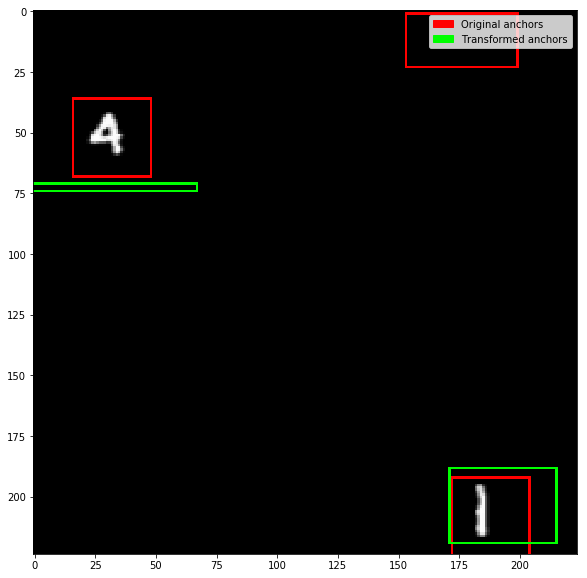

In [27]:
viz = cv2.merge([np.squeeze(images[idx], axis=-1)] * 3)
for y1, x1, y2, x2 in _anchors:
    cv2.rectangle(viz, (x1, y1), (x2, y2), (1, 0, 0), 1)
for y1, x1, y2, x2 in _bboxes:
    cv2.rectangle(viz, (x1, y1), (x2, y2), (0, 1, 0), 1)

plt.figure(figsize=(10, 10))
plt.legend(handles=[
    mpatches.Patch(color=(1, 0, 0), label='Original anchors'),
    mpatches.Patch(color=(0, 1, 0), label='Transformed anchors')
])
plt.imshow(viz);